## Combination of colour and number - To upload from dataset

This shows the combination of color detection and number detection. All the dataset is used for training data.
As test data, we use this test data.

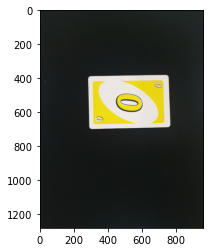

In [16]:
import cv2 as cv
import matplotlib.pyplot as plt

frame = cv.imread("DATASET/zero_Y.jpg") # dataset should be already uploaded into Jupyter notebook
                                        # pick an Uno card by changing the image name ,, for ex: "DATASET/nine_R.jpg" 
plt.imshow(frame[:,:,::-1])
plt.show()

In [17]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

### Load dataset

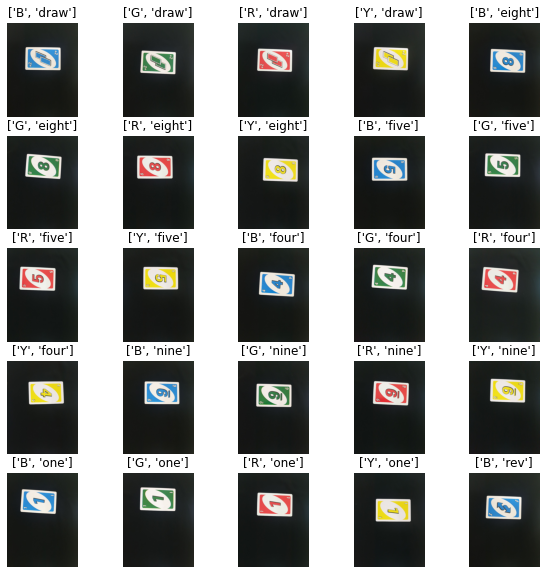

In [18]:
# Load dataset
images = []
labels = []

# Iterate through image files in dataset
fns = glob.glob("DATASET/*")
for fn in fns:
  # Load image
  img = cv.imread(fn)
  images.append(img)

  # Parse image filename for label
  bname = os.path.basename(fn) # only get filename ( remove directory path )
  rname, _ = os.path.splitext(bname) # remove extension


  
  # The second part is the color (R,G,B,Y)
  # rest is number (or special)
  name_parts = rname.split("_")
  color = name_parts[1]
  label = "_".join([name_parts[0]]+name_parts[2:])

  # Now color is R,G,B,Y
  # label is ZERO, TWO_DRAW, SKIP, ...
  labels.append([color, label])

# Show dataset
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  # Last indices is the reverse BGR to RGB
  # Opencv works in BGR, matplotlib need to display in RGB
  plt.imshow(images[i][:,:,::-1])
  plt.axis('off')
  plt.title(str(labels[i]))

### find_cards

This function will first apply an adaptive threshold which is
really effective for variable lighting situations,
a simple threshold can do badly with non-optimal
lighting.
                                                     
Next all EXTERNAL contours are detected on the image
which should each represent a card. Some noise
could be picked up so a minimum area is required.
                                                     
Finally the card contours is approximated with an
oriented bounding box. There are some adjustements
on the contour, which is then wrapped/cropped into
a separate image using wrapPersective

In [19]:
def find_cards(img):
  # Do adaptive threshold to find edges
  # Apply a gaussian blur before to 
  # make sure it doesn't pick up noisy edges
  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  gray = cv.GaussianBlur(gray, (21, 21), 0)
  th = cv.adaptiveThreshold(gray, 255,
      cv.ADAPTIVE_THRESH_GAUSSIAN_C,
      cv.THRESH_BINARY, 11, 2)

  # Get negative to find contours
  th = 255 - th 

  # We can notice there is a large area around
  # the uno card. We will use to our advantage.
  # In th, currently the image is a the edges
  # detected in the image. We apply some dilatation
  # to close any contour AND when cropping, make
  # sure that we don't get anything outside the card
  # When finding the contours, we get two contours
  # around the card. We pick the most inner one.
  # The dilatation process will make sure the inner
  # contour is exclusively inside the card
  


  kernel = np.ones((3, 3), np.uint8)
  th = cv.morphologyEx(th, cv.MORPH_DILATE, kernel, iterations=8)

  # Find contour in thresholded image
  contours, hierarchy = cv.findContours(th, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)

  
  card_contours = []

  for i, cnt in enumerate(contours):
    # Check that contour is external
    if hierarchy[0][i][3] == -1:
      # # Check that contour has child
      if hierarchy[0][i][2] != -1:
        # Check that contour has minimal area
        if cv.contourArea(contours[hierarchy[0][i][2]]) > np.size(th) * MIN_AREA_CARD:
          card_contours.append(hierarchy[0][i][2])


  card_imgs = []
  card_outlines = []

  for idx in card_contours:
    cnt = contours[idx]
    # Find oriented bounding box around card
    rect = cv.minAreaRect(cnt)
    box = cv.boxPoints(rect)

    # Have the most top-left first, and also 
    # the contour should be clockwise from the 
    # previous functions
    idx_leftop = np.argmin([p[0]+p[1] for p in box])
    box_ordered = []
    for j in range(4):
      box_ordered.append(box[(idx_leftop+j)%4])
    box = np.array(box_ordered)

    # Estimate card width and height

    box_l11 = np.linalg.norm(box[0]-box[1])
    box_l12 = np.linalg.norm(box[2]-box[3])

    box_l21 = np.linalg.norm(box[1]-box[2])
    box_l22 = np.linalg.norm(box[3]-box[0])

    box_l1 = (box_l11+box_l12)/2
    box_l2 = (box_l21+box_l22)/2

    # Card is straight
    new_width, new_height = None, None
    if box_l1 < box_l2:
      new_points = np.array([
        [0, 0], [box_l1, 0], [box_l1, box_l2], [0, box_l2]])
      new_width = box_l1
      new_height = box_l2

    # Card is on its side
    else:
      new_points = np.array([[box_l2, 0], [box_l2, box_l1], [0, box_l1], [0, 0]])
      new_width = box_l2
      new_height = box_l1

    # Compute perspective transform matrix and get wrapped
    # image which is only the card
    M = cv.getPerspectiveTransform(np.float32(box), np.float32(new_points))
    roi = cv.warpPerspective(img, M, (round(new_width), round(new_height)))

    card_imgs.append(roi)
    card_outlines.append(box)

  return card_imgs, card_outlines

### find_color_feature

In [20]:
CARD_SMALL_WIDTH = 30
CARD_RATIO = 1.5
CARD_SMALL_HEIGHT = round(CARD_SMALL_WIDTH*CARD_RATIO)

color_ranges = [
  [100, 105],
  [65, 75],
  [0, 5],
  [25, 30]
]

def find_color_feature(img):
  small = cv.resize(img, (CARD_SMALL_WIDTH, CARD_SMALL_HEIGHT), interpolation=cv.INTER_NEAREST)
  small_hsv = cv.cvtColor(small, cv.COLOR_BGR2HSV)
  hue_image = small_hsv[:,:,0]

  comp = []
  for j in range(4):
    th = cv.inRange(hue_image, color_ranges[j][0], color_ranges[j][1])
    comp.append(cv.countNonZero(th))

  comp = np.array(comp)

  return comp

### get_number_feature

In [21]:
CENTER_ROI_WIDTH = 200
CENTER_ROI_HEIGHT = 300

COUNT_GRID_X = 4
COUNT_GRID_Y = 6

def get_number_feature(img):
  # Convert image to grayscale
  gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  gray = cv.GaussianBlur(gray, (7, 7), 0)

  # Do an edge detection
  th = cv.adaptiveThreshold(gray, 255,
      cv.ADAPTIVE_THRESH_GAUSSIAN_C,
      cv.THRESH_BINARY, 11, 2)

  # Get negative to find contours
  th = 255 - th 

  kernel = np.ones((7, 7), np.uint8)
  th = cv.morphologyEx(th, cv.MORPH_CLOSE, kernel)

  # Create silhouette image
  # Each external contour is found in the image
  # and filled to create the silhouette image.
  contours, _ = cv.findContours(th, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

  silhouette = np.zeros_like(th)
  cv.drawContours(silhouette, contours, -1, 255, -1)

  # Crop the template in the center
  center = (silhouette.shape[1]//2, silhouette.shape[0]//2)
  roi = silhouette[center[1]-CENTER_ROI_HEIGHT//2:center[1]+CENTER_ROI_HEIGHT//2, 
      center[0]-CENTER_ROI_WIDTH//2:center[0]+CENTER_ROI_WIDTH//2]

  comp = []
  for ri in range(COUNT_GRID_Y):
    for rj in range(COUNT_GRID_X):
      local_roi = roi[int(ri*(CENTER_ROI_HEIGHT/COUNT_GRID_Y)):int((ri+1)*(CENTER_ROI_HEIGHT/COUNT_GRID_Y)),
        int(rj*(CENTER_ROI_WIDTH/COUNT_GRID_X)):int((rj+1)*(CENTER_ROI_WIDTH/COUNT_GRID_X))]
      comp.append(cv.countNonZero(local_roi))

  comp = np.array(comp)


  return comp


### Find card for each image

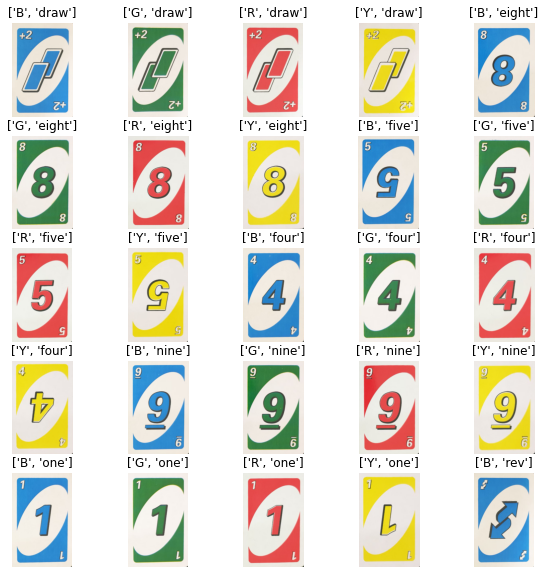

In [22]:
# This is the minimum area a card can have
# on an image. 0.1*width * 0.1*height.
MIN_AREA_CARD = 0.1*0.1

# For each train image, find the card inside it
# and only keep the card image
for i in range(len(images)):
  card_imgs, _ = find_cards(images[i])
  if len(card_imgs) != 1:
    # Multiple or zero cards detected in train data image
    print(f"Incorrect number of cards detected in {fns[i]}!")
  else:
    # Found one image, save it
    images[i] = card_imgs[0]

# Show dataset
plt.figure(figsize=(10,10))
for i in range(25):
  plt.subplot(5, 5, i+1)
  # Last indices is the reverse BGR to RGB
  # Opencv works in BGR, matplotlib need to display in RGB
  plt.imshow(images[i][:,:,::-1])
  plt.axis('off')
  plt.title(str(labels[i]))

### Normalize image sizes

In [23]:
# Card size after normlization
CARD_WIDTH = 400
CARD_RATIO = 1.5
CARD_HEIGHT = 600

# Normalize each card image
for i in range(len(images)):
  images[i] = cv.resize(images[i], (CARD_WIDTH, CARD_HEIGHT), interpolation=cv.INTER_AREA)

### Train for color

In [24]:
comps = []

for i in range(len(images)):
  comp = find_color_feature(images[i])
  comps.append(comp)

### Train for numbers

In [25]:
number_comps = []

for i in range(len(images)):
  comp = get_number_feature(images[i])
  number_comps.append(comp)

### Test with data

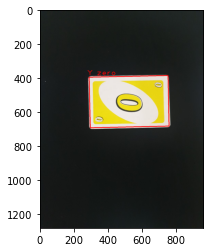

In [26]:
card_imgs, card_outlines = find_cards(frame)
if len(card_outlines) > 0:
  cv.drawContours(frame, np.int0(card_outlines), -1, (0, 0, 255), 4)

if len(card_imgs) > 0:
  # Normalize size for card from webcam feed
  for i in range(len(card_imgs)):
    card_imgs[i] = cv.resize(card_imgs[i], (CARD_WIDTH, CARD_HEIGHT), interpolation=cv.INTER_AREA)

  colors = []
  numbers = []

  # For each card, determine color and number
  for i in range(len(card_imgs)):
    comp = find_color_feature(card_imgs[i])
    closest_idx = np.argmin([np.linalg.norm(c - comp) for c in comps])

    comp = get_number_feature(card_imgs[i])

    dist_comp = [np.linalg.norm(c - comp) for c in number_comps]
    dist_comp_flip = [np.linalg.norm(c[::-1] - comp) for c in number_comps]

    match_idx = np.argmin(dist_comp)
    match_idx_flip = np.argmin(dist_comp_flip)

    if dist_comp[match_idx] < dist_comp_flip[match_idx_flip]:
      match_idx = match_idx
    else:
      match_idx = match_idx_flip


    # Pick closest match in contour
    predict_num = labels[match_idx][1]


    colors.append(labels[closest_idx][0])
    numbers.append(predict_num)

  for i in range(len(card_imgs)):
    x, y = np.int0(card_outlines[i][0])
    cv.putText(frame, colors[i] + " " + numbers[i], (x-10, y-10), cv.FONT_HERSHEY_PLAIN, 3.0, (0, 0, 255), thickness = 2, lineType=cv.LINE_AA)


plt.imshow(frame[:,:,::-1])
plt.show()